In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
from IPython.display import clear_output  # 引入 clear_output
# torch.manual_seed(seed=42)  

os.makedirs("fun_images", exist_ok=True)


In [10]:
layer_num=4
hidden_num=128

class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=128):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)+self.MLP(-x)

In [11]:
def potential(x):
    poten=x**2*2
    return poten

In [12]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
os.makedirs(f'./model_para_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
La=-10
Lb =10
L=Lb-La  # domain length
N = 800   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device,requires_grad=True)
grid=grid[1:-1].unsqueeze(-1)

en_num=40
extend_num=0
epoch=10000
lr=0.01
# 先给出固定的矩阵元素
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap


/tmp/ipykernel_226400/2513471731.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


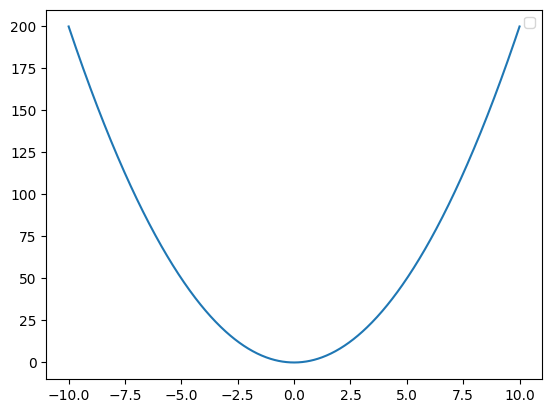

In [13]:
# 势函数演示图像
x_test=torch.linspace(La, Lb, N+2)
f1_test=potential(x_test)
plt.plot(x_test.numpy(), f1_test.numpy())
plt.legend()
plt.show()

In [14]:
# 计算初始的本征值
V_diag=potential(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)

print('initial eigenvalues check:')
print(eigenvalues[:en_num])

initial eigenvalues check:
tensor([ 0.9999,  2.9996,  4.9990,  6.9981,  8.9969, 10.9953, 12.9934, 14.9913,
        16.9887, 18.9859, 20.9828, 22.9793, 24.9755, 26.9715, 28.9672, 30.9625,
        32.9575, 34.9522, 36.9466, 38.9406, 40.9344, 42.9278, 44.9209, 46.9138,
        48.9063, 50.8985, 52.8903, 54.8819, 56.8731, 58.8641, 60.8547, 62.8449,
        64.8349, 66.8246, 68.8140, 70.8030, 72.7917, 74.7801, 76.7682, 78.7560],
       device='cuda:1', grad_fn=<SliceBackward0>)


In [15]:
def real_en(n):
    real_en=[2*i+1 for i in range(n)]
    torch_en=torch.tensor(real_en,dtype=dtype,device=device,requires_grad=False)
    return torch_en
######----------------------------------------------
# real_en=real_en(en_num)
real_en=eigenvalues[:en_num].detach()
######----------------------------------------------

In [16]:
model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=20,threshold=1e-4)
loss_fn=nn.MSELoss()

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    V_diag=model(grid)
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    
    output=eigenvalues[:en_num]
    
    val_loss=loss_fn(output,real_en)
    loss=val_loss
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    
    
    if i%10==0:
        # clear_output(wait=True)
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
        print(eigenvalues[:en_num])
        print(real_en)
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para_{layer_num}_{hidden_num}_{dtype}/model_para_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')
    
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para_{layer_num}_{hidden_num}_{dtype}/model_para_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')


epoch:0,loss:1418.1812744140625,time:0.014050006866455078,lr:0.01
tensor([-0.3590, -0.3586, -0.2285, -0.1725, -0.0624,  0.0709,  0.2287,  0.4133,
         0.6218,  0.8559,  1.1143,  1.3979,  1.7058,  2.0387,  2.3961,  2.7782,
         3.1850,  3.6162,  4.0723,  4.5528,  5.0582,  5.5878,  6.1423,  6.7213,
         7.3248,  7.9530,  8.6055,  9.2828,  9.9845, 10.7108, 11.4615, 12.2368,
        13.0365, 13.8608, 14.7093, 15.5824, 16.4799, 17.4018, 18.3482, 19.3187],
       device='cuda:1', grad_fn=<SliceBackward0>)
tensor([ 0.9999,  2.9996,  4.9990,  6.9981,  8.9969, 10.9953, 12.9934, 14.9913,
        16.9887, 18.9859, 20.9828, 22.9793, 24.9755, 26.9715, 28.9672, 30.9625,
        32.9575, 34.9522, 36.9466, 38.9406, 40.9344, 42.9278, 44.9209, 46.9138,
        48.9063, 50.8985, 52.8903, 54.8819, 56.8731, 58.8641, 60.8547, 62.8449,
        64.8349, 66.8246, 68.8140, 70.8030, 72.7917, 74.7801, 76.7682, 78.7560],
       device='cuda:1')
epoch:10,loss:47.33235168457031,time:0.12980055809020996,l

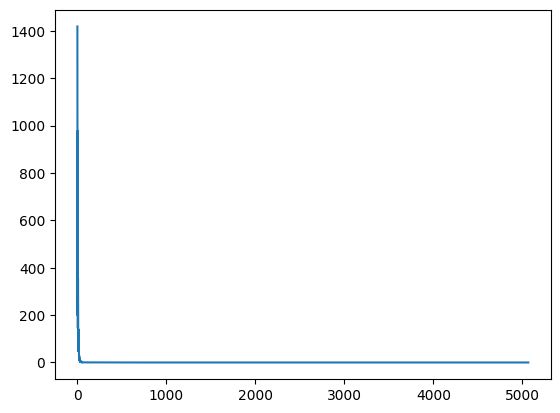

In [17]:
plt.plot(loss_list)
plt.show()

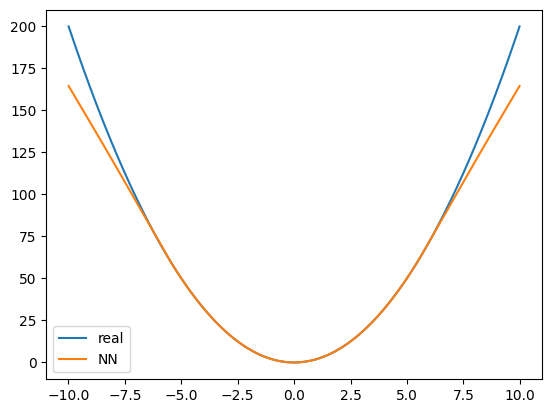

In [18]:
La=-10
Lb =10
L=Lb-La  # domain length
N = 2000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
V_NN=model(grid)
V_NN=V_NN.cpu().detach().numpy()
real_poten=potential(grid.cpu().detach().numpy())
plt.plot(grid.cpu().detach().numpy(),real_poten,label='real')
plt.plot(grid.cpu().detach().numpy(),V_NN,label='NN')
plt.legend()
plt.show()

In [19]:
# os.makedirs(f'./V_NN_value_{sym}_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
# torch.save(V_NN,f'./V_NN_value_{sym}_{layer_num}_{hidden_num}_{dtype}/V_NN_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')

In [20]:
error=V_NN-real_poten
mean_error=np.mean(np.abs(error))
max_error=np.max(np.abs(error))
print('mean_error:',mean_error)
print('max_error:',max_error)

mean_error: 4.8102303
max_error: 35.35173
